<a href="https://colab.research.google.com/github/GawainGan/Causal-Inference/blob/main/Causal%20Inference%20and%20Discovery%20in%20Python/Chap_9_Part_II_S_T_X_Learner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Package

In [1]:
!pip install dowhy==0.8 # fix the error: https://github.com/py-why/dowhy/issues/1028
!pip install econml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.3/287.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 15.8 MB/s eta 0:00:00


In [2]:
import sys
print(sys.version)

3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]


In [3]:
from copy import deepcopy

import numpy as np
import pandas as pd
from scipy import stats

from sklearn.metrics import mean_absolute_percentage_error

import dowhy
from dowhy import CausalModel

from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from lightgbm import LGBMRegressor, LGBMClassifier

import networkx as nx

from tqdm import tqdm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import graphviz

import warnings
warnings.filterwarnings('ignore')

dowhy.__version__

COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# S-Learner: The Lone Ranger

In [4]:
def plot_effect(effect_true, effect_pred, figsize=(10, 7), ylim=(5000, 22000)):
    plt.figure(figsize=figsize)
    plt.scatter(effect_true, effect_pred, color=COLORS[0])
    plt.plot(np.sort(effect_true), np.sort(effect_true), color=COLORS[1], alpha=.7, label='Perfect model')
    plt.xlabel('$True\ effect$', fontsize=14, alpha=.5)
    plt.ylabel('$Predicted\ effect$', fontsize=14, alpha=.5)
    plt.ylim(ylim[0], ylim[1])
    plt.legend()
    plt.show()

### Data load

In [5]:
# Train set
earnings_interaction_train = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Causal Inference and Discovery in Python/data/ml_earnings_interaction_train.csv')

# Test set
earnings_interaction_test = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Causal Inference and Discovery in Python/data/ml_earnings_interaction_test.csv')

In [6]:
earnings_interaction_train.shape, earnings_interaction_test.shape

((5000, 4), (100, 4))

In [25]:
print(earnings_interaction_train.head())

   age  python_proficiency  took_a_course  earnings
0   23            0.632318           True  139267.0
1   20            0.602551          False  115569.0
2   21            0.518225          False  119142.0
3   25            0.945161          False  130291.0
4   30            0.636251           True  164209.0


In [7]:
# Train
earnings_interaction_train.head()

,age,python_proficiency,took_a_course,earnings
0,23,0.632318,True,139267.0
1,20,0.602551,False,115569.0
2,21,0.518225,False,119142.0
3,25,0.945161,False,130291.0
4,30,0.636251,True,164209.0


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [26]:
print(earnings_interaction_test.head())

   age  python_proficiency  took_a_course  true_effect
0   30            0.223877           True      11120.0
1   23            0.394152           True      11970.0
2   37            0.214638           True      11073.0
3   21            0.869069           True      14345.0
4   41            0.833934           True      14169.0


In [8]:
# Test
earnings_interaction_test.head()

,age,python_proficiency,took_a_course,true_effect
0,30,0.223877,True,11120.0
1,23,0.394152,True,11970.0
2,37,0.214638,True,11073.0
3,21,0.869069,True,14345.0
4,41,0.833934,True,14169.0


As you can see, the test set’s structure is different. We don’t see the earnings column. Instead, we have a new column called true_effect.

### Define the graph

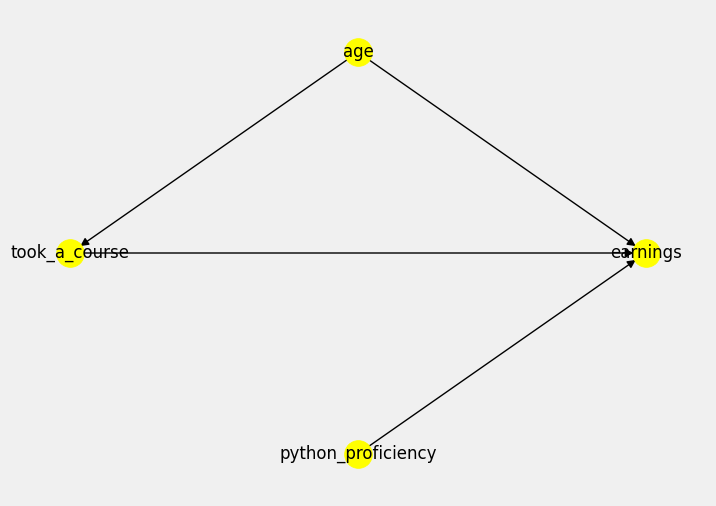

In [9]:
# Construct the graph (the graph is constant for all iterations)
nodes = ['took_a_course', 'python_proficiency', 'earnings', 'age']
edges = [
    ('took_a_course', 'earnings'),
    ('age', 'took_a_course'),
    ('age', 'earnings'),
    ('python_proficiency', 'earnings')
]

# Generate the GML graph
gml_string = 'graph [directed 1\n'

for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'

gml_string += ']'

# Instantiate the CausalModel
model = CausalModel(
    data=earnings_interaction_train,
    treatment='took_a_course',
    outcome='earnings',
    effect_modifiers='python_proficiency', # effect modifier variable is a variable that modifies the relationship between a treatment and an outcome
    graph=gml_string
)

model.view_model()

### Get the estimand

In [10]:
# Get the estimand
estimand = model.identify_effect()

print(estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                         
────────────────(E[earnings|age])
d[took_a_course]                 
Estimand assumption 1, Unconfoundedness: If U→{took_a_course} and U→earnings then P(earnings|took_a_course,age,U) = P(earnings|took_a_course,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Estimate the effect

In [11]:
# Get estimate (S-Learner)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.metalearners.SLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'overall_model': LGBMRegressor(n_estimators=500, max_depth=10)
        },
        'fit_params': {}
    })
# We do not pass any fit parameters to the estimator as we want to use the default values this time.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [12]:
estimate.cate_estimates.mean()

12547.068205674783

## Refutes(Two approaches)

### Random Common Cause

In [13]:
refutation = model.refute_estimate(
    estimand=estimand,
    estimate=estimate,
    method_name='random_common_cause')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [14]:
print(refutation)

Refute: Add a random common cause
Estimated effect:12547.068205674783
New effect:12548.987247639483
p value:0.98



随机共同原因（Random Common Cause）:通过添加一个随机变量作为潜在的共同原因来测试模型的稳健性。如果模型是稳健的，添加这个随机变量不应该显著改变估计的因果效应。

- 新的估计效应与原始估计效应非常接近。
- p值为0.98，远高于通常的显著性水平（如0.05）。这表示添加随机共同原因后，新的估计效应与原始估计效应之间没有统计学上的显著差异。

### Placebo Treatment

In [15]:
refutation = model.refute_estimate(
    estimand=estimand,
    estimate=estimate,
    method_name='placebo_treatment_refuter')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [16]:
print(refutation)

Refute: Use a Placebo Treatment
Estimated effect:12547.068205674783
New effect:-13.96173504724517
p value:0.9199999999999999



安慰剂处理（Placebo Treatment）:这种方法使用一个随机生成的"安慰剂"处理变量来替代真实的处理变量。如果模型是稳健的，它不应该为这个随机的安慰剂处理发现显著的因果效应。

- 新的估计效应接近于零，这是我们对安慰剂处理的预期。
- p值为0.92，同样远高于通常的显著性水平。这表示安慰剂处理的估计效应与零之间没有统计学上的显著差异。

### Two Refutation Test Conclusion

- 随机共同原因测试表明，即使在模型中引入潜在的混杂因素，估计的因果效应也保持稳定。
- 安慰剂处理测试表明，模型不会为随机的、无意义的"处理"发现虚假的因果效应。
- 两个测试的高p值（0.98和0.92）表明，模型在面对这些扰动时表现稳定，模型具有稳健性。

###Predict on test data

In [17]:
# Compute predictions
effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [18]:
# Compute the error
mean_absolute_percentage_error(effect_true, effect_pred)

0.050273209257800315

### Figure 9.10 - True effect (x axis) versus predicted effect (y axis) for S-Learner trained on full data

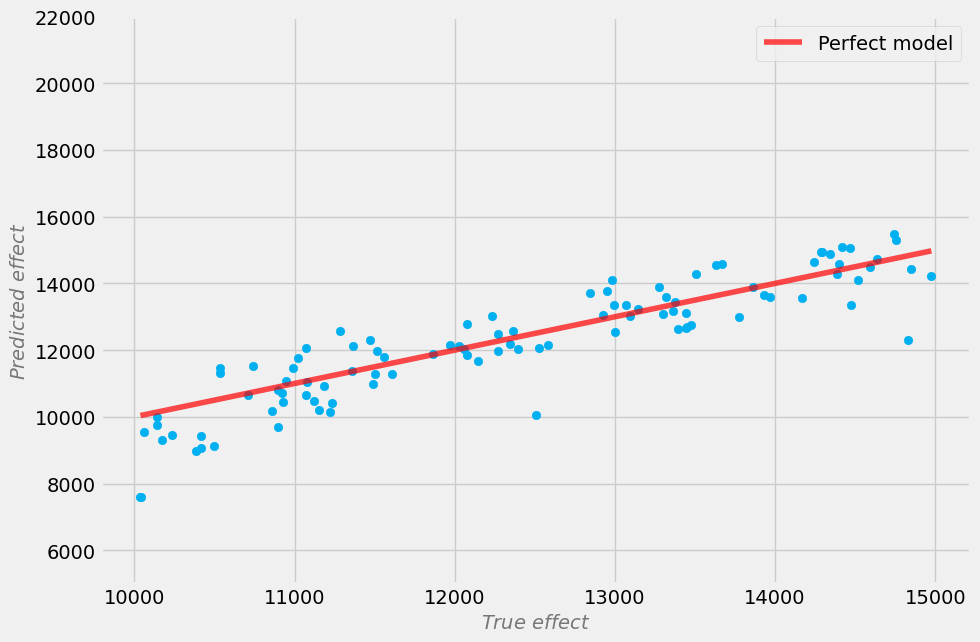

In [19]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

### Fit model with small dataset eg.sample(100)

In [20]:
# Instantiate the CausalModel
model_small = CausalModel(
    data=earnings_interaction_train.sample(100),
    treatment='took_a_course',
    outcome='earnings',
    effect_modifiers='python_proficiency',
    graph=gml_string
)

In [21]:
# Get estimate (S-Learner)
estimate = model_small.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.metalearners.SLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'overall_model': LGBMRegressor(n_estimators=500, max_depth=10)
        },
        'fit_params': {}
    })

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 4
[LightGBM] [Info] Start training from score 143592.930000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [22]:
# Compute predictions
effect_pred = model_small.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [23]:
# Compute the error
mean_absolute_percentage_error(effect_true, effect_pred)

0.12994794950299196

在原书中的结果是0.359，但在我们这里是0.151.虽然有很大的区别，但是这两个结果都比原始的MAPE(0.0502732092578003)要更大。

这就是小数据样本的问题，得到的误差是必然会更大的

### Figure 9.11 – The results for S-Learner trained on 100 observations

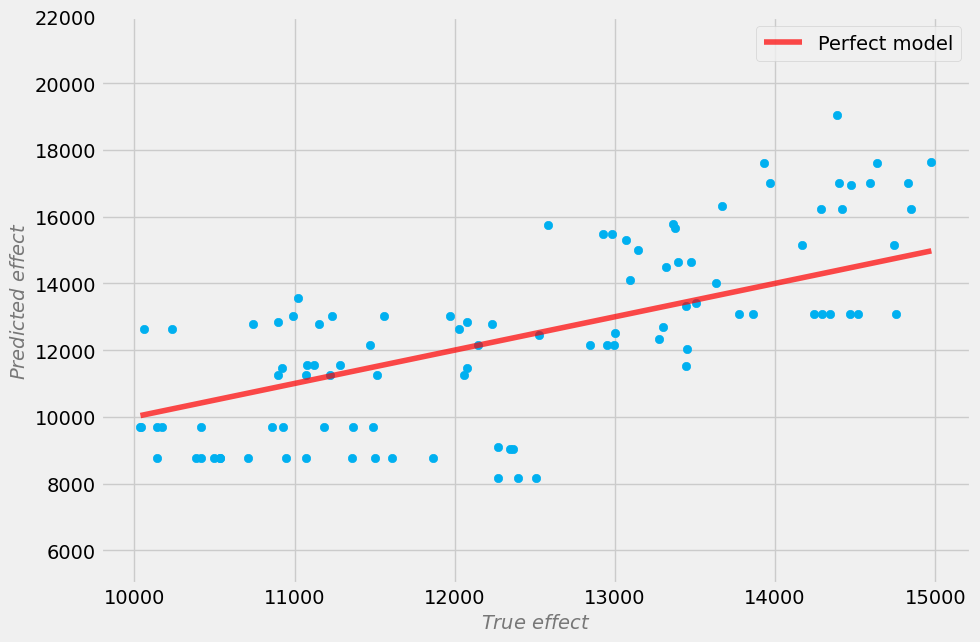

In [24]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

This model is very noisy to the extent that it’s almost unusable.

S-Learner 特点
1. 灵活性：S-Learner可以使用各种机器学习模型作为基础学习器。在这个例子中，使用了LGBMRegressor。
2. 简单性：S-Learner将处理变量视为普通特征之一，简化了模型结构。**但同时也是造成了他自身的局限性，特别是它可能低估因果效应的问题。这个问题源于S-Learner的核心特性：将处理变量视为普通特征**
3. 性能：在完整数据集上，S-Learner表现良好，MAPE只有0.0503。
4. 对样本量敏感：当使用小样本（100个样本）时，MAPE增加到0.130，表明S-Learner对样本量较为敏感。
5. 稳健性：通过反事实推理方法的验证，S-Learner展示了一定的稳健性。
6. 潜在的低估问题：虽然在这个例子中没有直接体现，但文本提到S-Learner可能会低估处理效应，特别是当效应较小时。

具体代码体现：

当使用基于树的模型（如LightGBM）时，如果处理效应相对较小，决策树可能不会选择在处理变量上进行分裂，导致模型忽视处理效应。类似地，使用正则化的线性模型（如Lasso）也可能将处理变量的系数压缩到零。

解决方案：

- 增加树的深度：这可以增加模型捕捉小效应的能力，但也增加了过拟合的风险。
- 使用其他元学习器：如T-Learner，它为处理组和对照组分别构建模型，避免了这个问题。
- 集成方法：结合多种估计器的结果，可能会得到更稳健的估计。

# T-Learner: Together We Can Do More

### Estimate the effect

In [27]:
# Get estimate (T-Learner)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.metalearners.TLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'models': [
                LGBMRegressor(n_estimators=200, max_depth=10),
                LGBMRegressor(n_estimators=200, max_depth=10)
            ]
        },
        'fit_params': {}
    })

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 287
[LightGBM] [Info] Number of data points in the train set: 3031, number of used features: 2
[LightGBM] [Info] Start training from score 141133.240845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [28]:
estimate.cate_estimates.mean()

12512.558912135146

### Predict on test data

In [29]:
# Compute predictions
effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

# Compute the error
mean_absolute_percentage_error(effect_true, effect_pred)

0.0813365927834967

The error is higher than the one for S-Learner(0.0502732092578003). The MAPE is now above 8%!

### Figure 9.13 – The results of the T-Learner model trained on full data

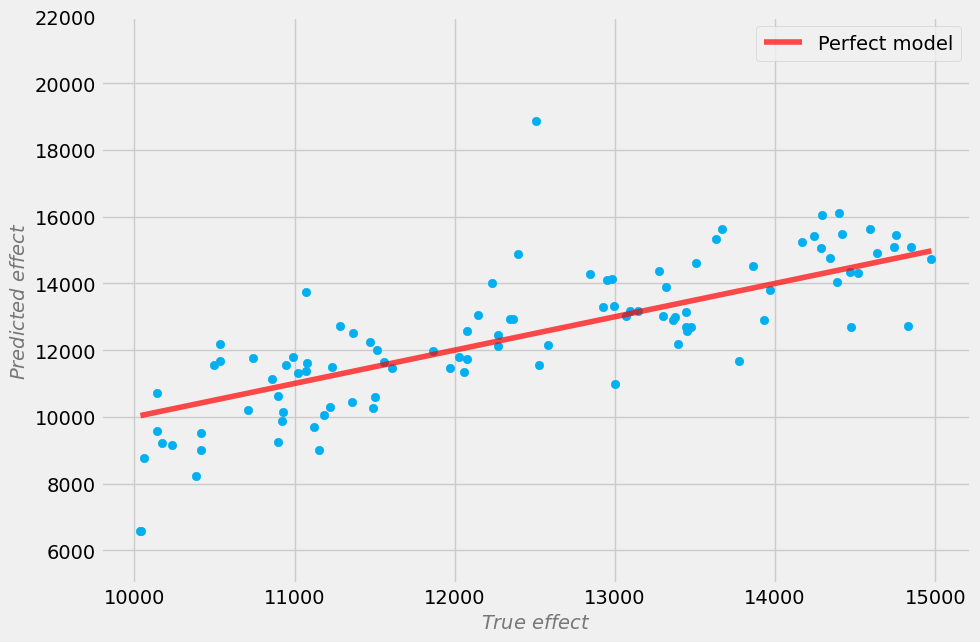

In [30]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

T-Learner focuses on improving just one aspect where S-Learner might (but does not have to) fail.

This improvement comes at a price. Fitting two algorithms to two different data subsets means that each algorithm is trained on fewer data, which can harm the fit quality.

It also makes T-Learner less data-efficient (you need twice as much data to teach each T-Learner’s base learner a representation of quality comparable to that in S-Learner).

# X-Learner – a step further

### Estimate the effect


In [31]:
# Get estimate (X-Learner)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.metalearners.XLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'models': [
                LGBMRegressor(n_estimators=50, max_depth=10),
                LGBMRegressor(n_estimators=50, max_depth=10)
            ],
            'cate_models': [
                LGBMRegressor(n_estimators=50, max_depth=10),
                LGBMRegressor(n_estimators=50, max_depth=10)
            ]
        },
        'fit_params': {},
    })

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 287
[LightGBM] [Info] Number of data points in the train set: 3031, number of used features: 2
[LightGBM] [Info] Start training from score 141133.240845
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 285
[LightGBM] [Info] Number of data points in the train set: 1969, number of used features: 2
[LightGBM] [Info] Start training from score 146213.957847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 287
[LightGBM] [Info] Number of data points in

In [32]:
# X-Learner with just one specified model - equivalent to the cell above
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.metalearners.XLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'models': LGBMRegressor(n_estimators=50, max_depth=10),
        },
        'fit_params': {},
    })

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 287
[LightGBM] [Info] Number of data points in the train set: 3031, number of used features: 2
[LightGBM] [Info] Start training from score 141133.240845
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 285
[LightGBM] [Info] Number of data points in the train set: 1969, number of used features: 2
[LightGBM] [Info] Start training from score 146213.957847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 287
[LightGBM] [Info] Number of data points in

In [33]:
estimate.cate_estimates.mean()


12564.919935370663

### Predict on test data


In [34]:
# Compute predictions
effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

# Compute the error
mean_absolute_percentage_error(effect_true, effect_pred)

0.03632496699577798

The MAPE for X-Learner is 3.6%. That’s more than twice as good as T-Learner’s 8.1% and around 32% better than S-Learner’s 5.2%!

### Figure 9.14 – X-Learner results

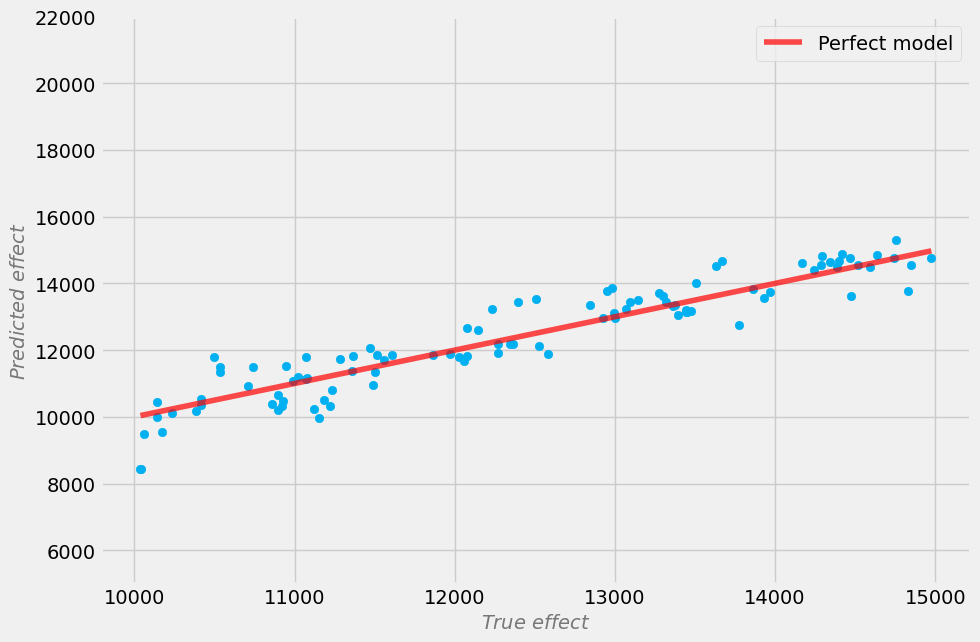

In [35]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

A summary of meta-learners’ results

|Estimator |MAPE|
|--|--|
|S-Learner |5.2%|
|T-Learner |8.1%|
|X-Learner |3.6%|


We can see that most points are focused around the red line. We don’t see clear outliers as in the case of S-Learner (Figure 9.10), and the overall error is much smaller than in the case of T-Learner (Figure 9.13).

## X-Learner on small data


In [36]:
# Get estimate (X-Learner)
estimate = model_small.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.metalearners.XLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'models': LGBMRegressor(n_estimators=50, max_depth=10)
        },
        'fit_params': {}
    })

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 2
[LightGBM] [Info] Start training from score 138135.094340
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [37]:
# Compute predictions
effect_pred = model_small.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values
# Compute the error
mean_absolute_percentage_error(effect_true, effect_pred)

0.11900163593528144

### Figure 9.15 – X-Learner’s results on small data

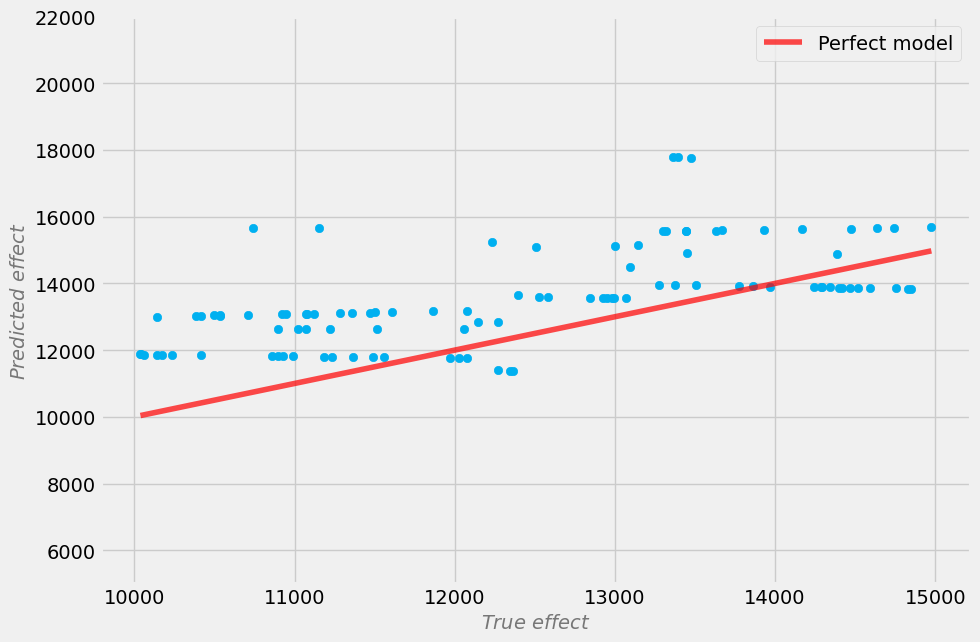

In [38]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

Figure 9.15 look slightly more structured than the ones for S-Learner on small data (Figure 9.11), but the MAPE is slightly higher (39% versus 36%).

That said, X-Learner usually outperforms S- and T-Learners when CATE is complex (e.g.,highly non-linear).